In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import MT5ForConditionalGeneration, AutoTokenizer
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from datasets import load_dataset
from evaluate import load
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm 
from scipy.stats import kurtosis
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt 
import evaluate
import torch
import time
import nltk
import numpy as np
import torch.nn.functional as F

nltk.download('wordnet')

/Users/jinhyunpark/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jinhyunpark/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Define metrics

In [2]:
# jhpark: verified that this is a correct way to use this 
def calculate_rouge(true_sentence, predicted_sentence):
    # jhpark: rouge1/rouge2 (e.g. rouge1, rouge2): n-gram based scoring.
    # jhpark: rougeL: Longest common subsequence based scoring.
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(true_sentence, predicted_sentence)
    return scores

In [3]:
# jhpark: verified that this is a correct way to use this 
def calculate_bleu(true_tokens, predicted_tokens):
    '''
    * reference for smoothing: A Systematic Comparison of Smoothing Techniques for Sentence-Level BLEU, Boxing Chen and Collin Cherry (2014)
    * method1: Smoothing method 1: Add *epsilon* counts to precision with 0 counts.
    * https://www.nltk.org/_modules/nltk/translate/bleu_score.html for more details
    '''
    bleu_score = sentence_bleu(true_tokens, predicted_tokens, smoothing_function=SmoothingFunction().method1)
    return bleu_score

### Datasets

In [4]:
# english to X is only possible for T5
from datasets import load_dataset, load_from_disk

# ds_de_en = load_dataset("wmt/wmt14", "de-en")
# ds_fr_en = load_dataset("wmt/wmt15", "fr-en")
# ds_ro_en = load_dataset("wmt/wmt16", "ro-en")

# ds_de_en.save_to_disk("../wmt14_de_en")
# ds_fr_en.save_to_disk("../wmt15_fr_en")
# ds_ro_en.save_to_disk("../wmt16_ro_en")

ds_de_en = load_from_disk("../wmt14_de_en")
ds_fr_en = load_from_disk("../wmt15_fr_en")
ds_ro_en = load_from_disk("../wmt16_ro_en")

### Models

In [5]:
t5_tokenizer_small = AutoTokenizer.from_pretrained('t5-small')
t5_model_small = AutoModelForSeq2SeqLM.from_pretrained('t5-small')
print("Done with small")

t5_tokenizer_base = AutoTokenizer.from_pretrained('t5-base')
t5_model_base = AutoModelForSeq2SeqLM.from_pretrained('t5-base')
print("Done with base")

Done with small
Done with base


### Init

In [6]:
def calculate_probs_from_logits(logits):
    return F.softmax(logits, dim=-1)

def generate_output_with_probs(model, tokenizer, example, top_k=5):
    '''
    - High Kurtosis: An indicator that the data has heavy tails or outliers.
    - Low Kurtosis:  An indicator that the data has thin tails and lacks outliers.
    '''
    inputs = tokenizer.encode(example, return_tensors="pt")
    output_ids = model.generate(inputs, max_new_tokens=np.inf, return_dict_in_generate=True, output_scores=True, return_legacy_cache=False)
    output_tokens = output_ids.sequences[0]
    output_probs = []
    output_kurtosis = []

    # Retrieve probabilities for each token
    for i, token_id in tqdm(enumerate(output_tokens)):
        if i == 0:  # Skip the initial token
            continue
        probs = calculate_probs_from_logits(output_ids.scores[i - 1])[0]
        token_prob = probs[token_id].item()  

        top_probs, _ = torch.topk(probs, 1000)
        kurt = kurtosis(top_probs)

        output_probs.append(token_prob)
        output_kurtosis.append(kurt)
        
    decoded_output = tokenizer.decode(output_tokens, skip_special_tokens=True)
    return decoded_output, np.array(output_probs), np.array(output_kurtosis)

### 1. Generate translations (English to German)

--------------- Sample 0 ---------------


11it [00:00, 1528.18it/s]

[Sentences]
   Input: translate English to German: Resumption of the session
   True Translation: Wiederaufnahme der Sitzungsperiode
   Predicted Translation: Wiederaufnahme der Sitzungsperiode

[Scores]
   BLEU score: 1.0
   METEOR score: 0.9993141289437586
   ROUGE scores: {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}

[Uncertainty Quantification]
   Length: 10
   Top 1 token probabilities: [0.994 0.999 0.996 0.994 1.    0.999 1.    1.    1.    0.999]
   Scaled kurtosis: [0.865 0.988 0.783 0.    1.    0.993 0.997 0.996 0.996 0.991]


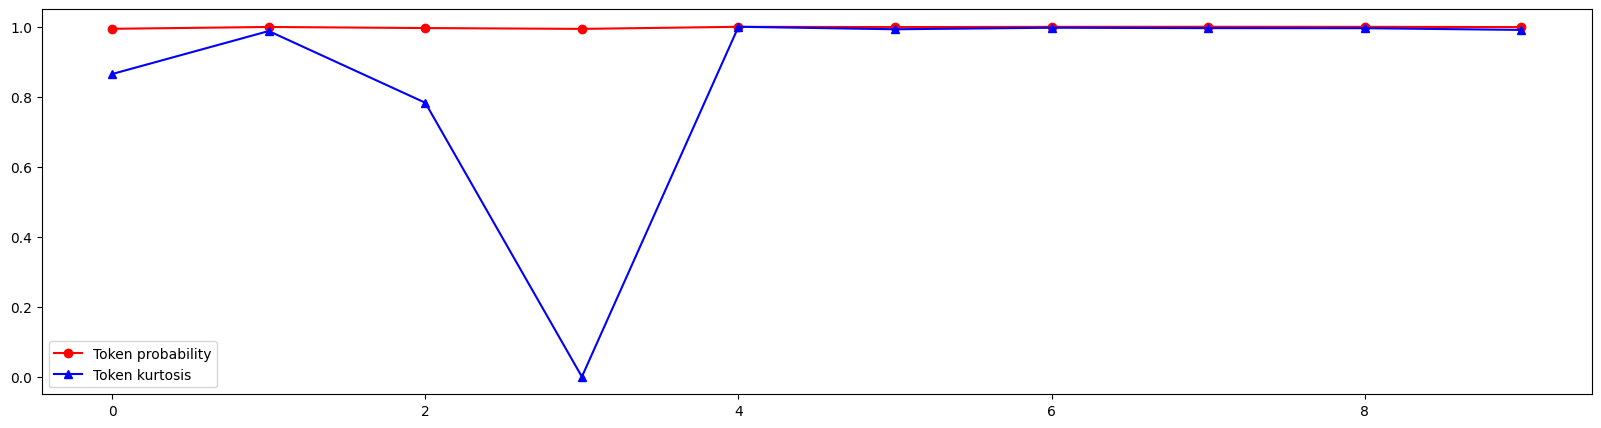

--------------- Sample 1 ---------------


62it [00:00, 1615.80it/s]


[Sentences]
   Input: translate English to German: I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.
   True Translation: Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.
   Predicted Translation: Ich erkläre die am Freitag, dem 17. Dezember 1999 unterbrochene Sitzungsperiode des Europäischen Parlaments für wieder aufgenommen, und ich möchte Ihnen erneut ein glückliches neues Jahr wünschen, in der Hoffnung, dass Sie einen angenehmen Festtag genießen.

[Scores]
   BLEU score: 0.4955474787092686
   METEOR score: 0.6400087260034905
   ROUGE scores: {'rouge1': Score(precision=0.4883720930232558, recall=0.6176470588235294, fmeasure=0.5454545454545455), 'rouge2': Score(

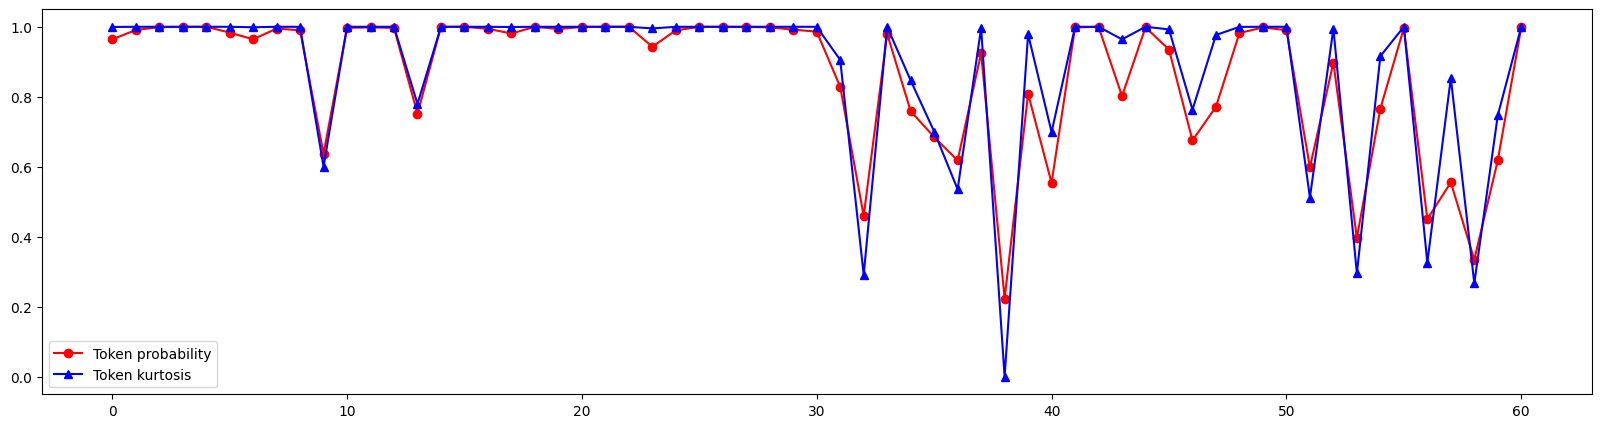

--------------- Sample 2 ---------------


65it [00:00, 1614.35it/s]

[Sentences]
   Input: translate English to German: Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.
   True Translation: Wie Sie feststellen konnten, ist der gefürchtete "Millenium-Bug " nicht eingetreten. Doch sind Bürger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden.
   Predicted Translation: Obwohl, wie Sie gesehen haben, der gefürchtete "Millennium-Fehler" nicht zustande kam, erlitten die Menschen in einigen Ländern noch immer eine Reihe von Naturkatastrophen, die wirklich schrecklich waren.

[Scores]
   BLEU score: 0.258758268765002
   METEOR score: 0.5387931034482759
   ROUGE scores: {'rouge1': Score(precision=0.26666666666666666, recall=0.3333333333333333, fmeasure=0.2962962962962963), 'rouge2': Score(precision=0.10344827586206896, recall=0.13043478260869565, fmeasure=0.11538461538461538), 'rougeL': Sc

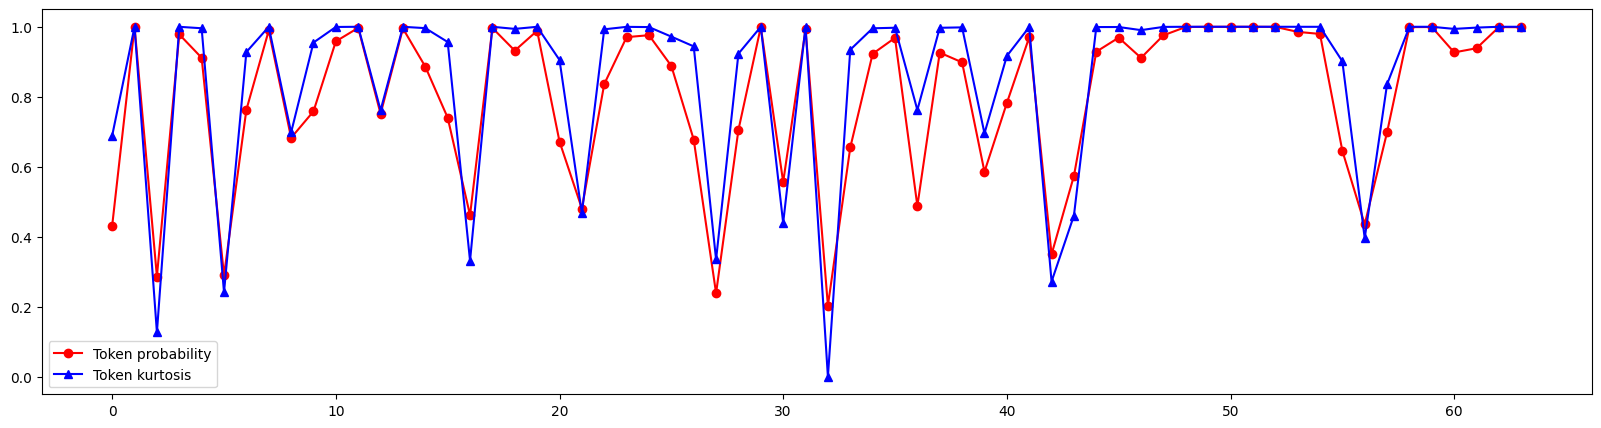

--------------- Sample 3 ---------------


28it [00:00, 1583.80it/s]

[Sentences]
   Input: translate English to German: You have requested a debate on this subject in the course of the next few days, during this part-session.
   True Translation: Im Parlament besteht der Wunsch nach einer Aussprache im Verlauf dieser Sitzungsperiode in den nächsten Tagen.
   Predicted Translation: Sie haben in den nächsten Tagen, während dieser Sitzung, eine Aussprache zu diesem Thema beantragt.

[Scores]
   BLEU score: 0.251696695878184
   METEOR score: 0.41573183760683763
   ROUGE scores: {'rouge1': Score(precision=0.4117647058823529, recall=0.4117647058823529, fmeasure=0.4117647058823529), 'rouge2': Score(precision=0.25, recall=0.25, fmeasure=0.25), 'rougeL': Score(precision=0.29411764705882354, recall=0.29411764705882354, fmeasure=0.29411764705882354)}

[Uncertainty Quantification]
   Length: 27
   Top 1 token probabilities: [0.867 0.977 0.435 0.957 0.994 0.885 0.996 0.565 0.409 0.993 0.815 0.986
 0.62  1.    0.849 0.633 0.679 1.    0.618 0.938 1.    0.992 0.826 0.9

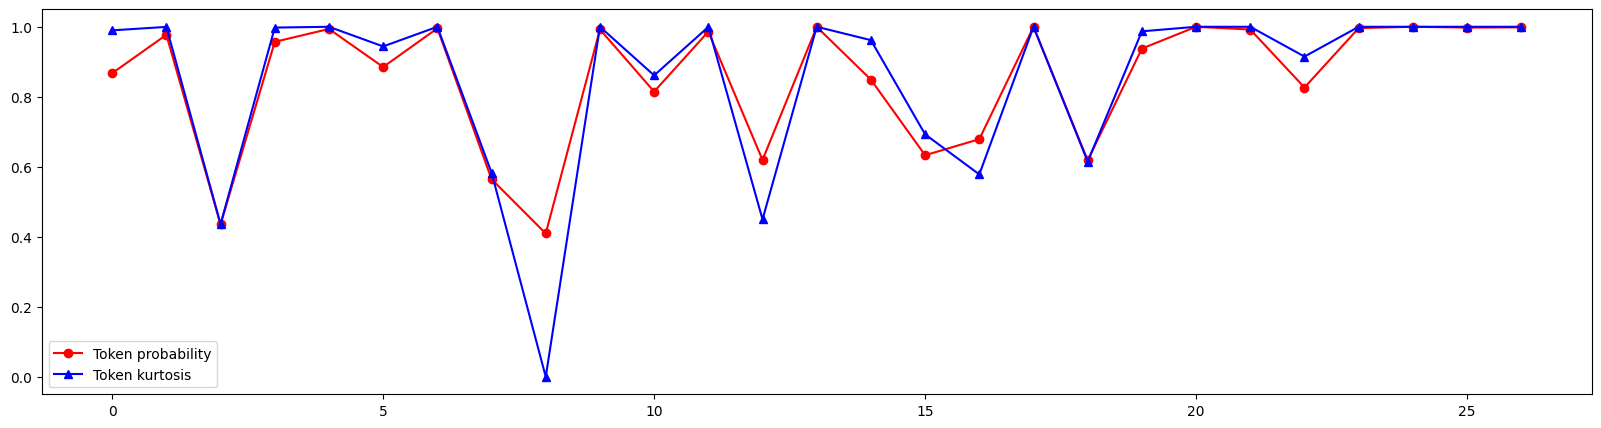

--------------- Sample 4 ---------------


58it [00:00, 1483.04it/s]

[Sentences]
   Input: translate English to German: In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the various countries of the European Union.
   True Translation: Heute möchte ich Sie bitten - das ist auch der Wunsch einiger Kolleginnen und Kollegen -, allen Opfern der Stürme, insbesondere in den verschiedenen Ländern der Europäischen Union, in einer Schweigeminute zu gedenken.
   Predicted Translation: In der Zwischenzeit möchte ich, wie einige Abgeordnete es gefordert haben, im Namen aller betroffenen Opfer, insbesondere der schrecklichen Stürme, in den verschiedenen Ländern der Europäischen Union eine Schweigeminute einlegen.

[Scores]
   BLEU score: 0.2910242261957368
   METEOR score: 0.5503142295750778
   ROUGE scores: {'rouge1': Score(precision=0.5882352941176471, recall=0.5714285714285714, fmeasure=0.5797101449275363), 'rouge2': Score(prec

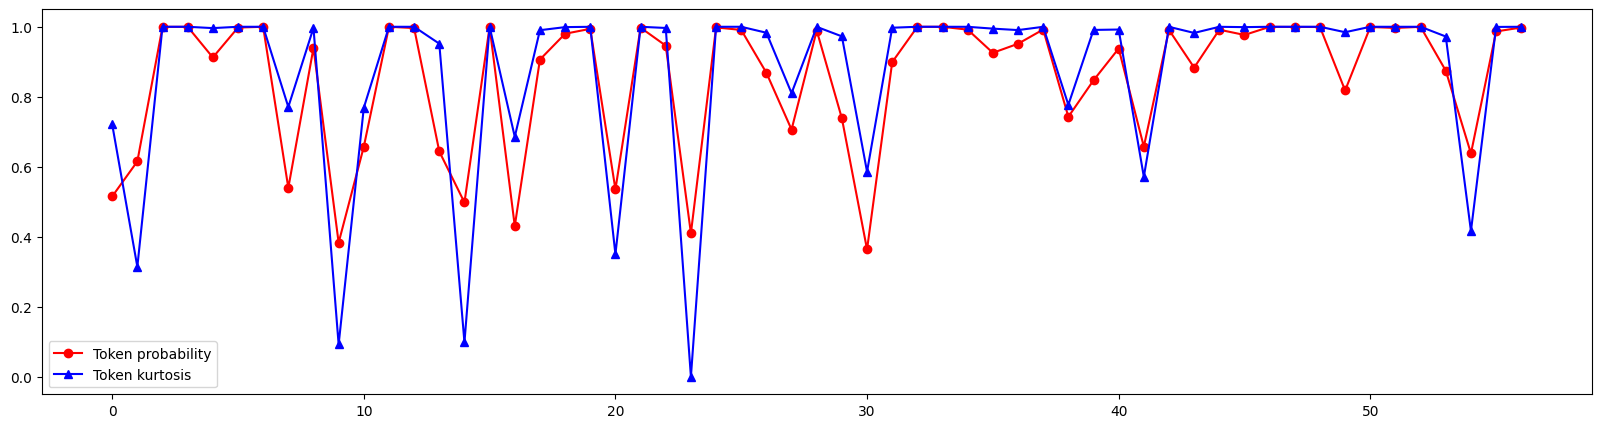

In [7]:
for i in range(5):
    print(f"--------------- Sample {i} ---------------")
    input_text = f"translate English to German: {ds_de_en['train'][i]['translation']['en']}"
    true_translation = ds_de_en['train'][i]['translation']['de']
    predicted_translation, token_probs, token_kurtosis = generate_output_with_probs(model=t5_model_small, tokenizer=t5_tokenizer_small, example=input_text)

    # tokenize 
    true_tokens = t5_tokenizer_small.tokenize(true_translation)
    predicted_tokens = t5_tokenizer_small.tokenize(predicted_translation)

    # uncertainty quantification using kurtosis 
    token_kurtosis = token_kurtosis.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_token_kurtosis = scaler.fit_transform(token_kurtosis).flatten() 

    # print 
    print("[Sentences]")
    print("   Input:", input_text)
    print("   True Translation:", true_translation)
    print("   Predicted Translation:", predicted_translation)

    print("\n[Scores]")
    bleu = calculate_bleu([true_tokens], predicted_tokens) # 1. BLEU
    print("   BLEU score:", bleu)
    meteor = meteor_score([true_tokens], predicted_tokens) # 2. METEOR (# jhpark: verified that this is a correct way to use this.)
    print("   METEOR score:", meteor)
    rouge = calculate_rouge(true_translation, predicted_translation) # 3. ROUGE
    print("   ROUGE scores:", rouge)

    print("\n[Uncertainty Quantification]")
    print(f"   Length: {len(token_probs)}")
    print(f"   Top 1 token probabilities: {np.round(token_probs, 3)}")
    print(f"   Scaled kurtosis: {np.round(scaled_token_kurtosis, 3)}")

    # visualization for token probability and kurtosis
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    ax.plot(np.arange(0, len(token_probs)), token_probs, label='Token probability', c='red', marker='o')
    ax.plot(np.arange(0, len(token_probs)), scaled_token_kurtosis, label='Token kurtosis', c='blue', marker='^')
    ax.legend()
    plt.show()
